## Objetivo

Gerar ilustrações para as características de cada defeito. 

Na inicialização abaixo são selecionadas amostras com a *maior severidade* de defeito, na *maior rotação*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# escolhe exemplares
NORMAL = '../mafaulda/normal/0/56.7296.csv'
DESBALANCEAMENTO = '../mafaulda/imbalance/35g/56.7296.csv'
DESALINHAMENTO_VERTICAL = '../mafaulda/vertical-misalignment/1.90mm/56.7296.csv'
DESALINHAMENTO_HORIZONTAL = '../mafaulda/horizontal-misalignment/1.5mm/56.5248.csv'

# agrupa exemplares
CAMINHOS = [NORMAL, DESBALANCEAMENTO, DESALINHAMENTO_VERTICAL, DESALINHAMENTO_HORIZONTAL]

# define eixo visualizado
EIXO = 'tg1'

# outros nomes
NOMES_DEFEITOS = (['normmal', 'desbalanceamento', 'dealinhamento vertical', 'desalinhamento horizontal'])
FREQUENCIA = 'frequencia_Hz'

Agora realizando a leitura e agrupando os dataframes

In [2]:
from initialize import Measurement

# listas que reúnem os dados
dataframes = []
arg_fundamentals = []

# itera para cada mensuração 
for i, exemplar in enumerate(CAMINHOS):
    m = Measurement(exemplar,50)
    dataframes.append(m.freq[['freq_ax', EIXO]])
    arg_fundamentals.append(m.fundamental)

# reúne todas as mensurações em um único DF
df = pd.concat(dataframes, 
          keys=NOMES_DEFEITOS, 
          names=['condição', 'index']
).reset_index()
df.pop('index')

# estiliza nomes de colunas e mostra-as
df.rename(columns={EIXO: 'Amplitude', 'freq_ax': FREQUENCIA}, inplace=True)
list(df.columns)

['condição', 'frequencia_Hz', 'Amplitude']

Agora podemos visualizar o espectro da frequência no eixo selecionado e nas leituras escolhidas.

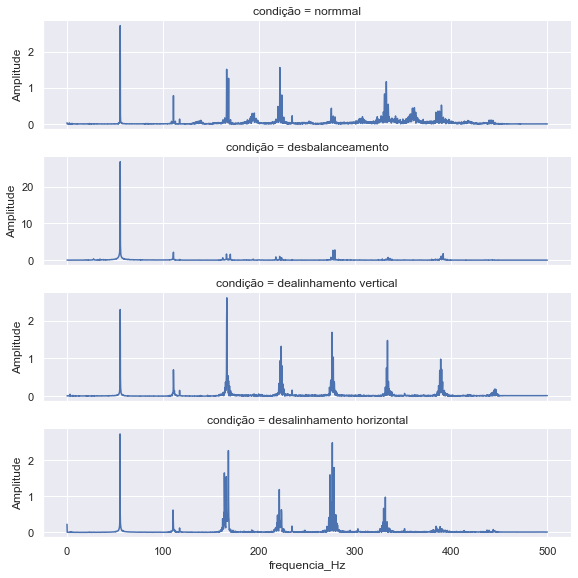

In [3]:
sns.relplot(
    data=df, x=FREQUENCIA, y='Amplitude', row='condição', kind='line', 
    facet_kws={'sharey': False, 'sharex': True}, height=2, aspect=4
)
plt.show()

Também podemos ver o periodigrama (o FFT ao quadrado). Ele fornece uma visão mais clara dos picos.

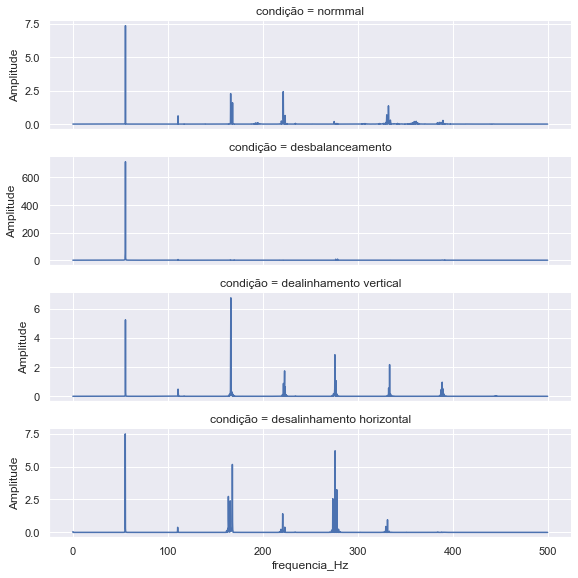

In [4]:
periodgram_df = df
periodgram_df['Amplitude'] = np.power(df['Amplitude'], 2)

sns.relplot(
    data=periodgram_df, x=FREQUENCIA, y='Amplitude', row='condição', kind='line', 
    facet_kws={'sharey': False, 'sharex': True}, height=2, aspect=4
)
plt.show()